Trabalho de RN - Utilizando Pytorch para classificação de imagens com máscara.

Treinamento feito para 3 novas classes: com máscara, sem máscara e máscara errada

Aluno: Flávio Amorim

Número: 211100510

Turma: 2021.1

Foi utilizado o Pytorch com a ResNet50 pré-treinada e feito o treinamento para as 03 novas classes.

O otimizador foi o SGD com os seguintes parâmetros:
*   lr=0.005
*   momentum=0.9
*   weight_decay=0.0005


O resultado no geral não foi satisfatório e pode-se reparar que em alguns erros o score apresentava um valor próximo a 1. Apenas para a classe "com máscara" o resultado foi bom.

Segue abaixo o detalhamento do resultado de 06 imagens e no final deste notebook essas imagens e predições estão exibidas:

*   Primeira imagem com apenas 01 pessoa:
        predicão "máscara errada" (score 0.0656) x label "sem máscara"     (ERROU)
        
*   Segunda imagem com apenas 01 pessoa:
        predicão "com máscara" x label "com máscara"        (ACERTOU)

*   Terceira imagem com 04 pessoas:
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" (score 0.9134) x label "máscara incorreta"  (ERROU)

*   Quarta imagem com 09 pessoas:
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)

*   Quinta imagem com 01 pessoa:
        predicão "com máscara" x label "com máscara"        (ACERTOU)

*   Sexta imagem com 03 pessoas:
        predicão "com máscara" (score 0.9975) x label  "sem máscara"        (ERROU)
        predicão "máscara incorreta" (score 0.1862) x label "com máscara"  (ERROU)
        não identificou o rosto x label "sem máscara"       (ERROU)

Melhorias a serem implementadas:
1.   Verificar um numero maior de épocas
2. Ajustar os hiperparâmetros do otimizador
3.   Refazer o treinamento, descartando as 39 imagens com mais de 15 pessoas, considerando-as como outliers (tem 02 imagens com mais de 100 pessoas)
4.   Utilizar outra rede pré-treinada
5.   Aplicar data augmentation para aperfeiçoar o treinamento





In [ ]:
#Referências:
#https://www.image-net.org/
#https://www.kaggle.com/code/flavioamorim/pytorch-fasterrcnn/edit
#https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

# 1 - Carregar as bibliotecas e mapear o Google Drive

In [ ]:
## Google drive
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/BI-Master/MascarasRESNET50'   # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np                                         # linear algebra
import pandas as pd                                        # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup                              # manipulacao dos arquivos xml com informacaoes das fotos

import torchvision                                         # Pytorch
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image                                      # manipulação de imagens
import matplotlib.pyplot as plt                            # graficos
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches                       # graficos

#2 - Verificando a base de dados para treinamento

In [ ]:
imgs = list(sorted(os.listdir("images/")))          # lista das imagens presentes no diretorio images
labels = list(sorted(os.listdir("annotations/")))   # lista dos xlm's presentes no diretorio annotations
print(f'Número de imagens: {len(imgs)}')
print(f'Número de anotações: {len(labels)}')


Número de imagens: 854
Número de anotações: 854


In [ ]:
#verificando quantas faces tem em cada figura
faces_in_obj  = []
file_name = []
for file in labels:
  file = "annotations/" + file
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')
    faces_in_obj.append(len(objects))
    file_name.append(file)   

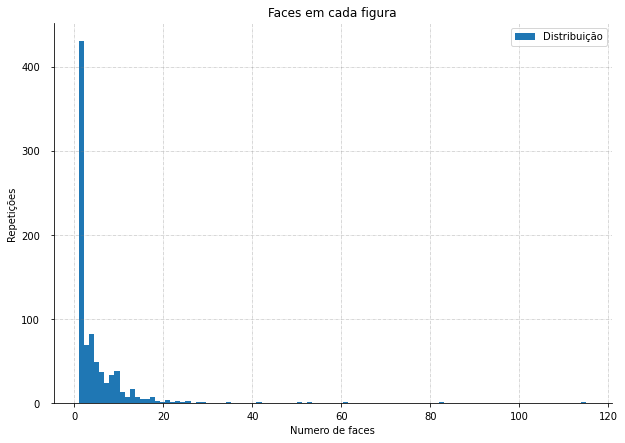

In [ ]:
# Creating histogram
# Verificou-se que tem imagens com mais de 100 faces.
# Serão descartadas imagens que tiverem mais de 15 faces
n_bins = 100
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(faces_in_obj, bins = n_bins)
for s in ['top','right']:
  ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

# Adding extra features   
plt.xlabel("Numero de faces")
plt.ylabel("Repetições")
legend = ['Distribuição']
plt.legend(legend)
plt.title('Faces em cada figura')

# Show plot
plt.show()

Verificando essas imagens com muitas faces

In [ ]:
indice = list(range(0,len(faces_in_obj)))
matrix_faces = list(zip(faces_in_obj, indice,file_name))
matrix_faces = sorted(matrix_faces,key=lambda x: (x[0],x[1]),reverse=True)
print(matrix_faces[0:3])


[(115, 561, 'annotations/maksssksksss603.xml'), (83, 466, 'annotations/maksssksksss518.xml'), (61, 158, 'annotations/maksssksksss240.xml')]


In [ ]:
print(matrix_faces[0:3])

[(115, 561, 'annotations/maksssksksss603.xml'), (83, 466, 'annotations/maksssksksss518.xml'), (61, 158, 'annotations/maksssksksss240.xml')]


In [ ]:
#print(matrix_faces)

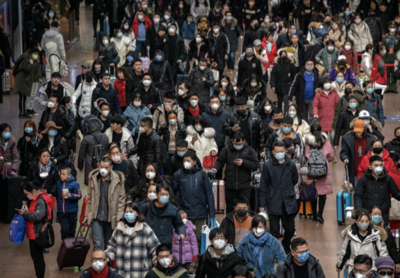

In [ ]:
from keras.preprocessing.image import load_img
imagem=load_img('images/maksssksksss603.png');imagem


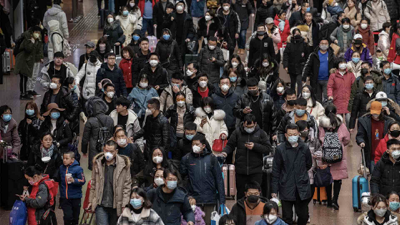

In [ ]:
imagem=load_img('images/maksssksksss518.png');imagem

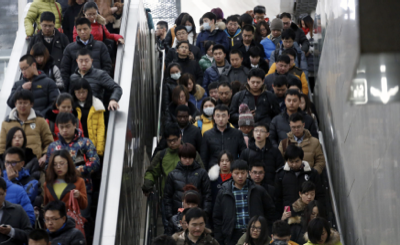

In [ ]:
imagem=load_img('images/maksssksksss240.png');imagem

In [ ]:
# Verificando:
# 1) conjunto de imagens com até 15 faces
# 2) conjunto de imagens com mais de 15 faces

faces_in_obj  = []
file_name = []
faces_in_outlier = []
outliers_name = []
for file in labels:
  file = "annotations/" + file
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')
    if (len(objects) > 15):
      # outlier
      faces_in_outlier.append(len(objects))
      outliers_name.append(file)
    else:
      faces_in_obj.append(len(objects))
      file_name.append(file)   

In [ ]:
print(f'Serão consideradas {len(outliers_name)} imagens como "outliers" (descartadas) por possuirem mais de 15 faces')
print(f'O novo total de imagens para serem treinadas é {len(file_name)}')


Serão consideradas 39 imagens como "outliers" (descartadas) por possuirem mais de 15 faces
O novo total de imagens para serem treinadas é 815


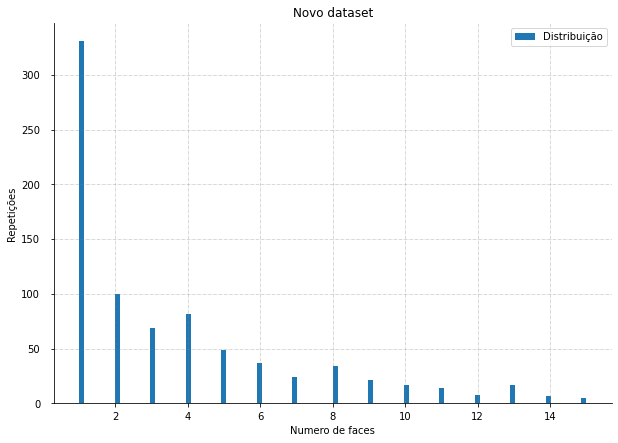

In [ ]:
# Creating histogram
n_bins = 100
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(faces_in_obj, bins = n_bins)
for s in ['top','right']:
  ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

# Adding extra features   
plt.xlabel("Numero de faces")
plt.ylabel("Repetições")
legend = ['Distribuição']
plt.legend(legend)
plt.title('Novo dataset')

# Show plot
plt.show()

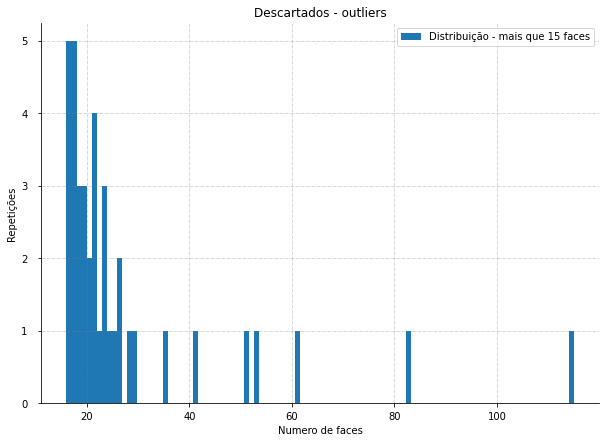

In [ ]:
# Creating histogram for outliers
n_bins = 100
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(faces_in_outlier, bins = n_bins)
for s in ['top','right']:
  ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

# Adding extra features   
plt.xlabel("Numero de faces")
plt.ylabel("Repetições")
legend = ['Distribuição - mais que 15 faces']
plt.legend(legend)
plt.title('Descartados - outliers')

# Show plot
plt.show()

# 3 - Funções auxiliares

In [ ]:
# funcao para retornar as coordenadas de um objeto de uma figura
# para poder desenhar o quadrado
# input = objeto
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

# funcao para retornar
# 1 com mascara 
# 2 máscaras com problema
# 0 sem mascara
# input = objeto
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

# funcao para criar um dict a partir do xml
# retorna o dict com a estrutura do objeto
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)
        
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes      # coordenadass do objeto
        target["labels"] = labels    # zero ou um
        target["image_id"] = img_id  # Tensorise img_id
        
        return target

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data    ### NAO FUNCIONOU QUANDO EM GPU, nem .cpu() nem .detach()
                                   ### necessario criar as variaveis temporarias a,b,c,d
    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box
        a = xmin.item()          # artificio para o problema acima
        b = ymin.item()          # artificio para o problema acima
        c = xmax.item()          # artificio para o problema acima
        d = ymax.item()          # artificio para o problema acima
        # Create a Rectangle patch

        #poderia ser como abaixo, mas nao funcionava em GPU
        #rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        rect = patches.Rectangle((a,b),(c-a),(d-b),linewidth=1,edgecolor='r',facecolor='none')
      
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

# 4 - Usando Transformers

In [ ]:
imgs = list(sorted(os.listdir("images/")))          # lista das imagens presentes no diretorio images

In [ ]:
labels = list(sorted(os.listdir("annotations/")))   # lista dos xlm's presentes no diretorio annotations

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("images/")))


    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=collate_fn)  # batch size alterado de 04 para 06

In [ ]:
# verifica se GPU est'a disponivel ( CUDA:0/CPU)
torch.cuda.is_available() 

False

# 5 - Criação do modelo, importando o pre-treinado resnet50

In [ ]:
# criacao do modelo, importando o pre-treinado resnet50
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# criando o modelo com 3 classes
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
## verificando GPU, para carregar no tensor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [ ]:
#até aqui
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    #print(annotations)
    break

# 6 - Treinamento do Modelo

No momento que este notebook foi salvo, não havia GPU disponível, então não foi feito um novo treinamento.

Para as predições, usei uma base que treinei quando havia GPU

In [ ]:
num_epochs = 25            ## Colab sen GPU nesse momento, entao usarei um modelo que treinei quanto GPU estava disponível
model.to(device)           ## nesse momento levado para CPU
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # utilizando SGD como otimizador

len_dataloader = len(data_loader)                 ## 214 imagens por epoca

for epoch in range(num_epochs):
    print(f'Epoca: {epoch}')                      ## exibir na tela numero da epoca
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:        ## para cada imagem do dataloader
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(f'Loss: {epoch_loss}')
    print('--------------------')

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

# 7 - Predict

In [ ]:
# fazer a predicao das imagens
model.eval()
preds = model(imgs)
preds

#Savando o Modelo

In [ ]:
# Trainamento não refeito e assim não salvo, pois o Colab está sem GPU disponível
#torch.save(model.state_dict(),'model-25-epoch.pt')

#Carrega o modelo salvo previamente com as 25 epocas

In [ ]:
model = get_model_instance_segmentation(3)

if torch.cuda.is_available():  # fazendo com GPU
  model.load_state_dict(torch.load('model-25-epoch.pt'))
else:  # fazendo agora com CPU
  model.load_state_dict(torch.load('model-25-epoch.pt',map_location=torch.device('cpu')))

model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#Predict, lembrando os labels:

"without_mask":          0

"with_mask":             1

"mask_weared_incorrect": 2


In [ ]:
imgs = list(sorted(os.listdir("images/"))) 
print(len(imgs))

854


In [ ]:
labels = list(sorted(os.listdir("annotations/")))   # lista dos xlm's presentes no diretorio annotations
print(len(labels))

854


In [ ]:
#imgs = list(img.to(device) for img in imgs)
#annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

In [ ]:
# NAO
#dataset = MaskDataset(data_transform)
#data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    #print(annotations)
    break

In [ ]:
pred = model(imgs)

# Resultado das 06 imagens



*   Primeira com apenas 01 pessoa:
        predicão "máscara errada" (score 0.0656) x label "sem máscara"     (ERROU)
        
*   Segunda com apenas 01 pessoa:
        predicão "com máscara" x label "com máscara"        (ACERTOU)

*   Terceira com 04 pessoas:
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" (score 0.9134) x label "máscara incorreta"  (ERROU)

*   Quarta com 09 pessoas:
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)
        predicão "com máscara" x label "com máscara"        (ACERTOU)

*   Quinta com 01 pessoa:
        predicão "com máscara" x label "com máscara"        (ACERTOU)

*   Sexta com 03 pessoas:
        predicão "com máscara" (score 0.9975) x label  "sem máscara"        (ERROU)
        predicão "máscara incorreta" (score 0.1862) x label "com máscara"  (ERROU)
        não identificou o rosto x label "sem máscara"       (ERROU)

Target


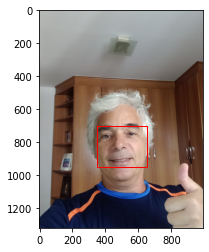

Predict with loaded model


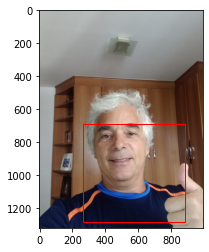

Label: tensor([2])
Target: tensor([0])
Scores: tensor([0.0656], grad_fn=<IndexBackward0>)


In [ ]:
print("Target")
plot_image(imgs[0], annotations[0])
print("Predict with loaded model")
plot_image(imgs[0], pred[0])
print(f"Label: {pred[0]['labels']}")
print(f"Target: {annotations[0]['labels']}")
print(f"Scores: {pred[0]['scores']}")

Target


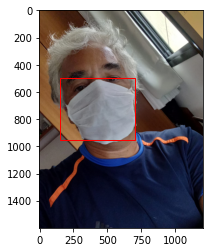

Predict with loaded model


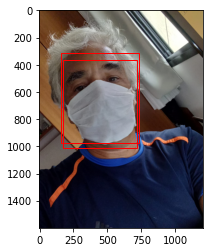

Label: tensor([1, 2])
Target: tensor([1])
Scores: tensor([0.9874, 0.1001], grad_fn=<IndexBackward0>)


In [ ]:
print("Target")
plot_image(imgs[1], annotations[1])
print("Predict with loaded model")
plot_image(imgs[1], pred[1])
print(f"Label: {pred[1]['labels']}")
print(f"Target: {annotations[1]['labels']}")
print(f"Scores: {pred[1]['scores']}")

Target


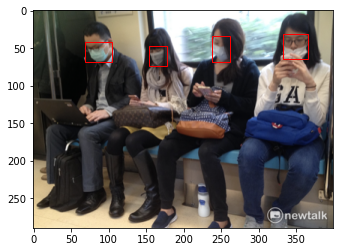

Predict with loaded model


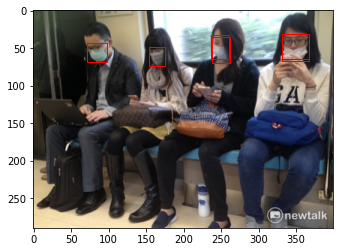

Label: tensor([1, 1, 1, 1, 2, 2])
Target: tensor([1, 1, 1, 2])
Scores: tensor([0.9968, 0.9918, 0.9665, 0.9134, 0.5309, 0.0700],
       grad_fn=<IndexBackward0>)


In [ ]:
print("Target")
plot_image(imgs[2], annotations[2])
print("Predict with loaded model")
plot_image(imgs[2], pred[2])
print(f"Label: {pred[2]['labels']}")
print(f"Target: {annotations[2]['labels']}")
print(f"Scores: {pred[2]['scores']}")

Target


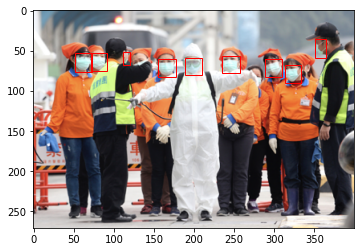

Predict with loaded model


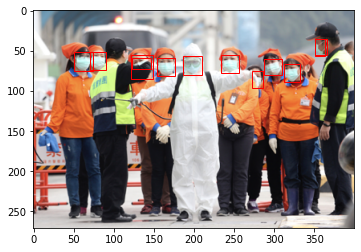

Label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])
Target: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Scores: tensor([0.9961, 0.9958, 0.9956, 0.9955, 0.9938, 0.9914, 0.9894, 0.4647, 0.2328,
        0.1363, 0.1295, 0.0968], grad_fn=<IndexBackward0>)


In [ ]:
print("Target")
plot_image(imgs[3], annotations[3])
print("Predict with loaded model")
plot_image(imgs[3], pred[3])
print(f"Label: {pred[3]['labels']}")
print(f"Target: {annotations[3]['labels']}")
print(f"Scores: {pred[3]['scores']}")

Target


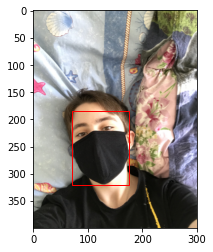

Predict with loaded model


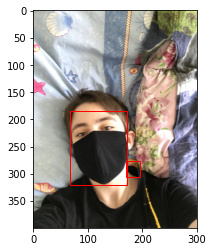

Label: tensor([1, 1])
Target: tensor([1])
Scores: tensor([0.9937, 0.4566], grad_fn=<IndexBackward0>)


In [ ]:
print("Target")
plot_image(imgs[4], annotations[4])
print("Predict with loaded model")
plot_image(imgs[4], pred[4])
print(f"Label: {pred[4]['labels']}")
print(f"Target: {annotations[4]['labels']}")
print(f"Scores: {pred[4]['scores']}")

Target


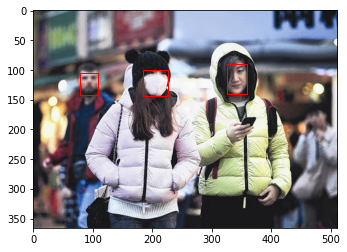

Predict with loaded model


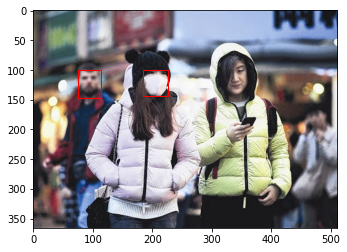

Label: tensor([1, 2])
Target: tensor([0, 1, 0])
Scores: tensor([0.9975, 0.1862], grad_fn=<IndexBackward0>)


In [ ]:
print("Target")
plot_image(imgs[5], annotations[5])
print("Predict with loaded model")
plot_image(imgs[5], pred[5])
print(f"Label: {pred[5]['labels']}")
print(f"Target: {annotations[5]['labels']}")
print(f"Scores: {pred[5]['scores']}")